# Policy comparison 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src.algorithm.backward_feature_selection import BackwardFeatureSelector
from src.algorithm.info_theory.combo_estimators import NpeetEstimator
from src.algorithm.utils import episodes_with_len
from src.envs.lqgNdim import LQG_nD
from src.wenvs import WrapperEnv

/home/daibak/.virtualenvs/feature_sel/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
weights = np.array([0.9, 0.9, 0.1, 0.1]*2)
Q = np.diag(weights[:4])
R = Q.copy()
env = LQG_nD(0.9, n_dim=4, Q=Q, R=R)
wenv = WrapperEnv(env, continuous_state=True, continuous_actions=True)

In [4]:
policy_dict = {'RND' : None, 
               'OPT_DET' : env.gaussianPolicy(env.computeOptimalK(), Sigma=0), 
               'OPT_RND' : env.gaussianPolicy(env.computeOptimalK(), Sigma=2), 
               'GAU_DET' : env.gaussianPolicy(env.computeOptimalK()*2, Sigma=0), 
               'GAU_RND' : env.gaussianPolicy(env.computeOptimalK()*2, Sigma=2)}

In [5]:
k = 20
k_ahead = 20
num_ep = 1000

traj_dict = {}
for pi in policy_dict:
    wenv.seed(0)
    trajectories = episodes_with_len(wenv, num_ep, k+k_ahead, policy=policy_dict[pi])
    traj_dict[pi] = trajectories

In [6]:
def evaluateFS(trajectories, k, gamma):
    fs = BackwardFeatureSelector(NpeetEstimator(), trajectories, nproc=1)
    return [(set(fs.idSet), 0.0)] + list(fs.try_all(k, gamma))

In [ ]:
fs_dict = {}
for pi in traj_dict:
    res = evaluateFS(traj_dict[pi], k, 0.9)
    fs_dict[pi] = res

In [8]:
for pi in fs_dict:
    print(pi)
    for i in fs_dict[pi]:
        print(i)

RND
({0, 1, 2, 3, 4, 5, 6, 7}, 0.0)
({0, 1, 2, 4, 5, 6, 7}, 59.6184899853323)
({0, 1, 2, 4, 5, 6}, 137.12495267980438)
({0, 1, 4, 5, 6}, 184.04844618393835)
({0, 1, 4, 5}, 269.06131087483647)
({0, 1, 5}, 475.7000770970794)
({1, 5}, 582.7550591602668)
({1}, 682.6743770406352)
(set(), 782.2583300584851)
OPT_DET
({0, 1, 2, 3, 4, 5, 6, 7}, 0.0)
({0, 1, 3, 4, 5, 6, 7}, 1.4418336848108359e-07)
({0, 1, 4, 5, 6, 7}, 2.0390607517458586e-07)
({0, 1, 5, 6, 7}, 4.605350945041377e-06)
({0, 1, 6, 7}, 6.452141584080397e-06)
({0, 1, 6}, 0.0007157961016097007)
({0, 1}, 0.0009671340236242585)
({0}, 238.50833161396173)
(set(), 291.3717630493637)
OPT_RND
({0, 1, 2, 3, 4, 5, 6, 7}, 0.0)
({0, 1, 3, 4, 5, 6, 7}, 2.1197838386655374)
({0, 1, 4, 5, 6, 7}, 12.028825272180875)
({0, 1, 4, 5, 7}, 35.42332330466001)
({0, 1, 4, 5}, 53.04288974674453)
({0, 1, 5}, 154.76431913897096)
({0, 1}, 210.47946524491076)
({0}, 344.1665854236418)
(set(), 416.1501801912648)
GAU_DET
({0, 1, 2, 3, 4, 5, 6, 7}, 0.0)
({0, 1, 2, 3, 4,

In [6]:
def score_fs(history, weights):
    res = []
    for S in history:
        score = weights[list(S)].sum() / (len(S) + 1)
        res.append(score)
    return np.array(res)

In [7]:
score_dict = {}
for pi in fs_dict:
    hist = map(lambda x: x[0], fs_dict[pi])
    score_dict[pi] = score_fs(hist, weights)

In [8]:
def ideal_hist(weights):
    S = set(range(len(weights)))
    hist = [S.copy()]
    for i in np.argsort(weights):
        S.remove(i)
        hist.append(S.copy())
    return hist

In [9]:
score_dict['Ideal'] = score_fs(ideal_hist(weights), weights)

In [13]:
def plot_scores(score_dict):
    markers = ["x", "o", "*", "s", "^", "v"]
    plt.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(9,5), constrained_layout=True)
    ax = plt.subplot(111)
    for pi, m in zip(score_dict, markers):
        y = score_dict[pi]
        x = np.arange(len(y))
        ax.step(x, y, where='mid', label=pi, marker=m, alpha=0.3)
    ax.legend()
    plt.xlabel("Number of Features Removed")
    plt.ylabel("Score")
    plt.title("Policy Comparison")
    plt.show()
    return fig

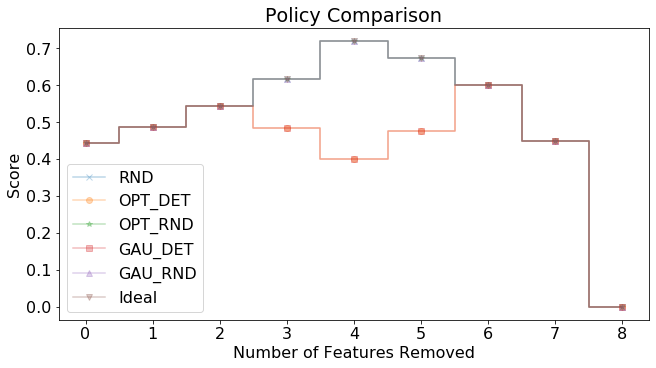

In [14]:
fig = plot_scores(score_dict)

In [15]:
fig.savefig("images/policy-comparison.png")